# Download and process sentinel 2 data

## John Brandt
## April 1, 2020

## Package imports, API import, source scripts

In [1]:
import datetime
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import scipy.sparse as sparse
import seaborn as sns
import yaml

from collections import Counter
from osgeo import ogr, osr
from random import shuffle
from scipy.sparse.linalg import splu
from sentinelhub import WmsRequest, WcsRequest, MimeType
from sentinelhub import CRS, BBox, constants, DataSource, CustomUrlParam
from skimage.transform import resize

with open("../config.yaml", 'r') as stream:
        key = (yaml.safe_load(stream))
        API_KEY = key['key'] 
        
%matplotlib inline
%run ../src/preprocessing/slope.py
%run ../src/preprocessing/indices.py
%run ../src/downloading/utils.py
%run ../src/preprocessing/cloud_removal.py
%run ../src/preprocessing/whittaker_smoother.py
%run ../src/dsen2/utils/DSen2Net.py

Using TensorFlow backend.


## Parameters

In [2]:
# Parameters
SUPER_RESOLVE = True
YEAR = 2019
TIME = ('{}-12-01'.format(str(YEAR - 1)), '{}-02-01'.format(str(YEAR + 1)))
EPSG = CRS.WGS84
IMSIZE = 48
DATA_LOCATION = '../data/ghana-test.csv'
OUTPUT_FOLDER = '../data/test-smooth-200/'

# For DSen2 superresolve
MDL_PATH = "../src/dsen2/models/"
INPUT_SHAPE = ((4, None, None), (6, None, None))
MODEL = s2model(INPUT_SHAPE, num_layers=6, feature_size=128)
PREDICT_FILE = MDL_PATH+'s2_032_lr_1e-04.hdf5'
MODEL.load_weights(PREDICT_FILE)

# Constants
starting_days = np.cumsum([0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30])
c_arr = np.array([[1, 1, 1, 1, 1,],
                  [1, 2, 2, 2, 1,],
                  [1, 2, 3, 2, 1,],
                  [1, 2, 2, 2, 1,],
                  [1, 1, 1, 1, 1,],])
                  
c_arr = c_arr / 3
o_arr = 1 - c_arr
c_arr = np.tile(c_arr[:, :, np.newaxis], (1, 1, 11))
o_arr = np.tile(o_arr[:, :, np.newaxis], (1, 1, 11))

Instructions for updating:
Colocations handled automatically by placer.


# Helper functions

In [3]:
def DSen2(d10, d20):
    """Super resolves 20 meter bans using the DSen2 convolutional
       neural network, as specified in Lanaras et al. 2018
       https://github.com/lanha/DSen2

        Parameters:
         d10 (arr): (4, X, Y) shape array with 10 meter resolution
         d20 (arr): (6, X, Y) shape array with 20 meter resolution

        Returns:
         prediction (arr): (6, X, Y) shape array with 10 meter superresolved
                          output of DSen2 on d20 array
    """
    test = [d10, d20]
    input_shape = ((4, None, None), (6, None, None))
    prediction = _predict(test, input_shape, deep=False)
    return prediction

def _predict(test, input_shape, model = MODEL, deep=False, run_60=False):
    
    prediction = model.predict(test, verbose=1)
    return prediction

# Bounding boxes

In [4]:
def calc_bbox(plot_id, df):
    """ Calculates the corners of a bounding box from an input
        pandas dataframe as output by Collect Earth Online

        Parameters:
         plot_id (int): plot_id of associated plot
         df (pandas.DataFrame): dataframe of associated CEO survey
    
        Returns:
         bounding_box (list): [(min(x), min(y)),
                              (max(x), max_y))]
    """
    subs = df[df['PLOT_ID'] == plot_id]
    # TOP, LEFT, BOTTOM, RIGHT
    # (min x, min y), (max x, max y)
    return [(min(subs['LON']), min(subs['LAT'])),
            (max(subs['LON']), max(subs['LAT']))]

def bounding_box(points, expansion = 160):
    """ Calculates the corners of a bounding box with an
        input expansion in meters from a given bounding_box
        
        Subcalls:
         calculate_epsg, convertCoords

        Parameters:
         points (list): output of calc_bbox
         expansion (float): number of meters to expand or shrink the
                            points edges to be
    
        Returns:
         bl (tuple): x, y of bottom left corner with edges of expansion meters
         tr (tuple): x, y of top right corner with edges of expansion meters
    """
    bl = list(points[0])
    tr = list(points[1])
    inproj = Proj('epsg:4326')
    outproj_code = calculate_epsg(bl)
    outproj = Proj('epsg:' + str(outproj_code))
    
    bl_utm =  transform(inproj, outproj, bl[1], bl[0])
    tr_utm =  transform(inproj, outproj, tr[1], tr[0])

    distance1 = tr_utm[0] - bl_utm[0]
    distance2 = tr_utm[1] - bl_utm[1]
    expansion1 = (expansion - distance1)/2
    expansion2 = (expansion - distance2)/2
        
    bl_utm = [bl_utm[0] - expansion1, bl_utm[1] - expansion2]
    tr_utm = [tr_utm[0] + expansion1, tr_utm[1] + expansion2]

    #assert (tr_utm[0] - bl_utm[0]) == expansion
    #assert (tr_utm[1] - bl_utm[1]) == expansion

    zone = str(outproj_code)[3:]
    zone = zone[1:] if zone[0] == "0" else zone
    direction = 'N' if tr[1] >= 0 else 'S'
    utm_epsg = "UTM_" + zone + direction
    return (bl_utm, tr_utm), CRS[utm_epsg]

# Data download

In [5]:
def identify_clouds(bbox, epsg, time = TIME):

    for try_ in range(0, 5):
        try:
            box = BBox(bbox, crs = epsg)
            cloud_request = WmsRequest(
                layer='CLOUD_NEW',
                bbox=box,
                time=time,
                width=96,
                height=96,
                image_format =  MimeType.TIFF_d8,
                maxcc=0.75,
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
                time_difference=datetime.timedelta(hours=48))
            
            shadow_request = WmsRequest(
                layer='SHADOW',
                bbox=box,
                time=time,
                width=96,
                height=96,
                image_format =  MimeType.TIFF_d16,
                maxcc=0.75,
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
                time_difference=datetime.timedelta(hours=48))

            cloud_img = cloud_request.get_data()
            cloud_img = np.array(cloud_img)

            if np.max(cloud_img > 10):
                cloud_img = cloud_img / 255
            assert np.max(cloud_img) <= 1.
            print("Cloud_probs shape: {}".format(cloud_img.shape))
            
            shadow_img = shadow_request.get_data()
            shadow_img = np.array(shadow_img)
            print("Shadows_shape: {}".format(shadow_img.shape))

            if np.max(shadow_img > 10):
                shadow_img = shadow_img / 65535
            
            shadows = mcm_shadow_mask(np.array(shadow_img), cloud_img)
            shadow_percent = np.sum(shadows, axis = (1, 2))
            
            cloud_percent = np.sum(cloud_img > 0.33, axis = (1, 2))
            bad_percent = shadow_percent + cloud_percent
            bad_percent = bad_percent / (96 * 96)
            starting_days = [-30, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 335, 400]
            
            clean_steps = np.argwhere(np.array(bad_percent) < 0.11).flatten()
            
            dates = []
            for date in cloud_request.get_dates():
                if date.year == YEAR - 1:
                    dates.append(-365 + starting_days[(date.month-1)] + date.day)
                if date.year == YEAR:
                    dates.append(starting_days[(date.month-1)] + date.day)
                if date.year == YEAR + 1:
                    dates.append(365 + starting_days[(date.month-1)]+date.day)
            dates = np.array(dates)
            
            for i, val in enumerate(starting_days[1:]):
                good_dates = dates[np.logical_and(dates > starting_days[i], dates < val)]
                good_idx = [i for i, val in enumerate(dates) if val in good_dates]
                cloud_probs = bad_percent[good_idx]
                clean_dates = [x for x in cloud_probs if x < 0.1]
                print(i, clean_dates)
                
            cloud_img = cloud_img[clean_steps, 24:-24, 24:-24]
            shadows = shadows[clean_steps, 24:-24, 24:-24]
            return cloud_img, shadows, list(clean_steps)
        except Exception as e:
            logging.fatal(e, exc_info=True)
    
    
def download_dem(plot_id, df, epsg, image_format = MimeType.TIFF_d32f):
    """ Downloads MapZen digital elevation model and return slope

        Parameters:
         plot_id (tuple): plot id from collect earth online (CEO)
         df (pandas.DataFrame): data associated with plot_id from CEO
         epsg (int): UTM EPSG associated with plot_id
    
        Returns:
         slope (arr): (X, Y, 1) array of per-pixel slope from [0, 1]
    """
    location = calc_bbox(plot_id, df = df)
    bbox, epsg = bounding_box(location, expansion = (IMSIZE+2)*10)
    box = BBox(bbox, crs = epsg)
    dem_request = WmsRequest(data_source=DataSource.DEM,
                         layer='DEM',
                         bbox=box,
                         width=IMSIZE+2,
                         height=IMSIZE+2,
                         instance_id=API_KEY,
                         image_format= image_format,
                         custom_url_params={CustomUrlParam.SHOWLOGO: False})
    dem_image = dem_request.get_data()[0]
    slope = calcSlope(dem_image.reshape((1, IMSIZE+2, IMSIZE+2)),
                      np.full((IMSIZE+2, IMSIZE+2), 10),
                      np.full((IMSIZE+2, IMSIZE+2), 10), 
                      zScale = 1, minSlope = 0.02)
    slope = slope.reshape((IMSIZE+2, IMSIZE+2, 1))
    slope = slope[1:IMSIZE+1, 1:IMSIZE+1, :]
    return slope

        
def download_layer(bbox, epsg, clean_steps: np.ndarray, time = TIME,
                   image_format = MimeType.TIFF_d16):
    """ Downloads the L2A sentinel layer with 10 and 20 meter bands
        
        Parameters:
         bbox (list): output of calc_bbox
         epsg (float): EPSG associated with bbox 
         time (tuple): YY-MM-DD - YY-MM-DD bounds for downloading 
    
        Returns:
         img (arr):
         img_request (obj): 
    """
    try:
        box = BBox(bbox, crs = epsg)
        image_request = WcsRequest(
                layer='L2A20',
                bbox=box,
                time=time,
                image_format = image_format,
                data_source = DataSource.SENTINEL2_L2A,
                maxcc=0.75,
                resx='20m', resy='20m',
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'NEAREST',
                                    constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
                time_difference=datetime.timedelta(hours=48),
            )
        img_bands = image_request.get_data(data_filter = clean_steps)
        img_20 = np.stack(img_bands)

        if np.max(img_20) >= 10:
            img_20 = img_20 / 65535
        assert np.max(img_20) <= 2.

        s2_20_usage = (img_20.shape[1]*img_20.shape[2])/(512*512) * (6/3) * img_20.shape[0]
        print("Original 20 meter bands size: {}, using {} PU".format(img_20.shape, s2_20_usage))
        img_20 = resize(img_20, (img_20.shape[0], IMSIZE, IMSIZE, img_20.shape[-1]), order = 0)
        
        image_request = WcsRequest(
                layer='L2A10',
                bbox=box,
                time=time,
                image_format = image_format,
                data_source = DataSource.SENTINEL2_L2A,
                maxcc=0.75,
                resx='10m', resy='10m',
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'BICUBIC',
                                    constants.CustomUrlParam.UPSAMPLING: 'BICUBIC'},
                time_difference=datetime.timedelta(hours=48),
        )
        
        img_bands = image_request.get_data(data_filter = clean_steps)
        img_10 = np.stack(img_bands)
        print("The original L2A image size is: {}".format(img_10.shape))
        img_10 = resize(img_10, (img_10.shape[0], IMSIZE, IMSIZE, img_10.shape[-1]), order = 0)
        img = np.concatenate([img_10, img_20], axis = -1)

        if np.max(img_10) >= 10:
            img_10 = img_10 / 65535
        assert np.max(img_10) <= 2.
        return img, image_request

    except Exception as e:
        logging.fatal(e, exc_info=True)

# Cloud and shadow removal

In [6]:
def remove_missed_clouds(img):
    """ Removes steps that are likely to be missed cloud or shadows
        based on two interquartile ranges for the near infrared band
        
        Parameters:
         img (arr):

        Returns:
         to_remove (list): 
    """
    iqr = np.percentile(img[:, :, :, 3].flatten(), 75) - np.percentile(img[:, :, :, 3].flatten(), 25)
    thresh_t = np.percentile(img[:, :, :, 3].flatten(), 75) + iqr*2
    thresh_b = np.percentile(img[:, :, :, 3].flatten(), 25) - iqr*2
    diffs_fw = np.diff(img, 1, axis = 0)
    diffs_fw = np.mean(diffs_fw, axis = (1, 2, 3))
    diffs_fw = np.array([0] + list(diffs_fw))
    diffs_bw = np.diff(np.flip(img, 0), 1, axis = 0)
    diffs_bw = np.flip(np.mean(diffs_bw, axis = (1, 2, 3)))
    diffs_bw = np.array(list(diffs_bw) + [0])
    diffs = abs(diffs_fw - diffs_bw) * 100 # 3, -3 -> 6, -3, 3 -> 6, -3, -3
    #diffs = [int(x) for x in diffs]
    outlier_percs = []
    for step in range(img.shape[0]):
        bottom = len(np.argwhere(img[step, :, :, 3].flatten() > thresh_t))
        top = len(np.argwhere(img[step, :, :, 3].flatten() < thresh_b))
        p = 100* ((bottom + top) / (IMSIZE*IMSIZE))
        outlier_percs.append(p)
    to_remove = np.argwhere(np.array(outlier_percs) > 15)
    return to_remove

# Download function

In [7]:
def download_plots(data_location = DATA_LOCATION, output_folder = OUTPUT_FOLDER, image_format = MimeType.TIFF_d16):
    """ Downloads slope and sentinel-2 data for all plots associated
        with an input CSV from a collect earth online survey
        
        Parameters:
         data_location (os.path)
         output_folder (os.path)
        
        Subcalls:
         calc_bbox, bounding_box
         identify_clouds, download_layer, check_zenith, download_dem
         remove_clouds_and_shadows, remove_missed_clouds
         DSen2
         calculate_and_save_best_images
         
        Creates:
         output_folder/{plot_id}.npy
    
        Returns:
         None
    """
    df = pd.read_csv(data_location)
    for column in ['IMAGERY_TITLE', 'STACKINGPROFILEDG', 'PL_PLOTID', 'IMAGERYYEARDG',
                  'IMAGERYMONTHPLANET', 'IMAGERYYEARPLANET']:
        if column in df.columns:
            df = df.drop(column, axis = 1)
    df = df.dropna(axis = 0)
    plot_ids = sorted(df['PLOT_ID'].unique())
    existing = [int(x[:-4]) for x in os.listdir(output_folder) if ".DS" not in x]
    to_download = [x for x in plot_ids if x not in existing]
    print(f"STARTING DOWNLOAD OF {len(to_download)} plots from {data_location} to {output_folder}")
    errors = []
    for i, val in enumerate(to_download):
        print(f"Downloading {i+1}/{len(to_download)}, {val}")
        initial_bbx = calc_bbox(val, df = df)
        sentinel2_bbx, epsg = bounding_box(initial_bbx, expansion = IMSIZE*10)
        cloud_bbx, _ = bounding_box(initial_bbx, expansion = 96*10)
        clouds, shadows, clean_steps = identify_clouds(cloud_bbx, epsg = epsg)
        dem = download_dem(val, epsg = epsg, df = df)
        img, image_request = download_layer(sentinel2_bbx, clean_steps = clean_steps,
                                            epsg = epsg, image_format = image_format)


        # Calculate imagery dates
        image_dates = []
        for date in image_request.get_dates():
            if date.year == YEAR - 1:
                image_dates.append(-365 + starting_days[(date.month-1)] + date.day)
            if date.year == YEAR:
                image_dates.append(starting_days[(date.month-1)] + date.day)
            if date.year == YEAR + 1:
                image_dates.append(365 + starting_days[(date.month-1)]+date.day)
        image_dates = [val for idx, val in enumerate(image_dates) if idx in clean_steps]
        image_dates = np.array(image_dates, dtype = np.float32)

        # Remove imagery where >4% is clouds, and where there is null data
        cloud_steps = np.argwhere(np.sum(clouds > 0.33, (1, 2)) > (16 * 16 * 0.10))
        missing_images = np.sum(img == 0.0, axis = (1, 2, 3))
        missing_images_p = np.sum(img >= 1.0, axis = (1, 2, 3))
        missing_images += missing_images_p
        missing_images = np.argwhere(missing_images >= 50)
        to_remove = np.concatenate([missing_images, cloud_steps])
        to_remove = np.unique(to_remove)

        # Remove null steps
        print(f"There are {len(to_remove)}/{len(img)} dirty steps")

        img = np.delete(img, to_remove, 0)
        clouds = np.delete(clouds, to_remove, 0)
        image_dates = np.delete(image_dates, to_remove)
        shadows = np.delete(shadows, to_remove, 0)

        to_remove = remove_missed_clouds(img)
        img = np.delete(img, to_remove, 0)
        clouds = np.delete(clouds, to_remove, 0)
        image_dates = np.delete(image_dates, to_remove)
        shadows = np.delete(shadows, to_remove, 0)
        print(f"Removing {len(to_remove)} steps based on ratio")

        # Concatenate DEM
        dem = np.tile(dem.reshape((1, IMSIZE, IMSIZE, 1)), (img.shape[0], 1, 1, 1))
        tiles = np.concatenate([img, dem], axis = -1)
        tiles[:, :, :, -1] /= 90

        x, interp = remove_cloud_and_shadows(tiles, clouds, shadows, image_dates)
        to_remove = np.argwhere(np.mean(interp, axis = (1, 2, 3)) > 0.5)
        x = np.delete(x, to_remove, 0)
        clouds = np.delete(clouds, to_remove, 0)
        image_dates = np.delete(image_dates, to_remove)
        shadows = np.delete(shadows, to_remove, 0)
        print(f"Removing {len(to_remove)} steps with >50% interpolation")

        x = x[:, 8:40, 8:40, :]
        print(f"Shape before super: {x.shape}")

        d10 = x[..., 0:4]
        d20 = x[..., 4:10]

        d10 = np.swapaxes(d10, 1, -1)
        d10 = np.swapaxes(d10, 2, 3)
        d20 = np.swapaxes(d20, 1, -1)
        d20 = np.swapaxes(d20, 2, 3)
        superresolved = DSen2(d10, d20)
        superresolved = np.swapaxes(superresolved, 1, -1)
        superresolved = np.swapaxes(superresolved, 1, 2)

        # returns band IDXs 3, 4, 5, 7, 8, 9
        x[..., 4:10] = superresolved
        x = x[:, 8:24, 8:24, :]
        print(f"Shape after super: {x.shape}")

        # Calculate indices
        tiles = evi(x, True)
        tiles = bi(tiles, True)
        tiles = msavi2(tiles, True)
        x = si(tiles, True)
        
        
        missing_pixels = 0
        for band in range(0, 15):
            for time in range(0, x.shape[0]):
                x_i = x[time, :, :, band]
                missing_pixels += len(np.argwhere(np.isnan(x_i)))
                x_i[np.argwhere(np.isnan(x_i))] = np.mean(x_i)
                x[time, :, :, band] = x_i
        print(f"There are {missing_pixels} missing pixels")
        # Interpolate linearly to 5 day frequency
        tiles, max_distance = calculate_and_save_best_images(x, image_dates)
        
        
        
        # Smooth linear interpolation
        sm = Smoother(lmbd = 800, size = tiles.shape[0], nbands = 14, dim = 16)
        tiles = sm.interpolate_array(tiles)
        print(f"There are {np.sum(np.isnan(tiles))} NA values")
        #sns.scatterplot(tiles[:, 3, 3, 1], [x for x in range(tiles.shape[0])])
        if max_distance <= 240:
            np.save(output_folder + str(val), tiles)
            print(f"Saved array of {tiles.shape} shape to {val}")
            print("\n")
        else:
            print(f"Skipping {val} because there is a {max_distance} distance")
            print("\n")

In [8]:
for i in os.listdir("../data/train-csv/"):
    if "lac-south-train" in i:
    #if ".csv" in i:
        #if any(x in i for x in ["africa-west", "cameroon", "koure", "niger"]):
        x, dates = download_plots("../data/train-csv/" + i, "../data/train-s2-monthly/", image_format = MimeType.TIFF_d16)

STARTING DOWNLOAD OF 118 plots from ../data/train-csv/lac-south-train.csv to ../data/train-s2-monthly/


/Users/john.brandt/anaconda3/envs/remote_sensing/lib/python3.6/site-packages/sentinelhub/data_request.py:47: SHDeprecationWarning: Parameter 'instance_id' is deprecated and will soon removed. Use parameter 'config' instead
  category=SHDeprecationWarning)


Cloud_probs shape: (76, 96, 96)
Shadows_shape: (76, 96, 96, 3)



0 [0.08680555555555555, 0.0, 0.0]
1 [0.022786458333333332]
2 [0.0]
3 [0.0]
4 []
5 [0.030381944444444444]
6 [0.027777777777777776]
7 []
8 [0.0]
9 [0.0, 0.001736111111111111]
10 [0.0]
11 [0.0]
Original 20 meter bands size: (13, 24, 24, 6), using 0.05712890625 PU
The original L2A image size is: (13, 48, 48, 4)
There are 0/13 dirty steps
Removing 0 steps based on ratio
Interpolated 0 px
Removing 0 steps with >50% interpolation
Shape before super: (13, 32, 32, 11)
13/13 [==============================] - 0s 36ms/step
Shape after super: (13, 16, 16, 11)
There are 0 missing pixels
0 {'image_date': [-11.0, 24.0], 'image_ratio': [0.6857142857142857, 0.3142857142857143], 'image_idx': [0, 1]}
5 {'image_date': [-11.0, 24.0], 'image_ratio': [0.5428571428571429, 0.45714285714285713], 'image_idx': [0, 1]}
10 {'image_date': [-11.0, 24.0], 'image_ratio': [0.4, 0.6], 'image_idx': [0, 1]}
15 {'image_date': [-11.0, 24.0], 'image_ratio': [0.2571428571428571, 0.7428571428571429], 'image_idx': [0, 1]}
20 {'

KeyboardInterrupt: 

In [9]:
x = np.load("../data/train-s2-monthly/136134405.npy")
y = np.load("../data/train-s2/136134405.npy")

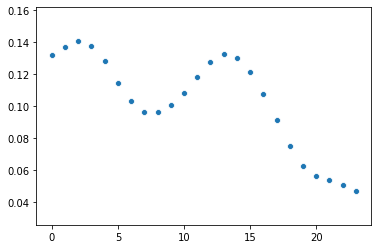

In [28]:
sns.scatterplot(np.arange(24), x[:, 5, 5, -3])

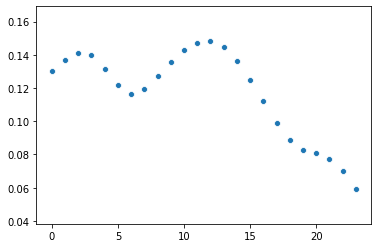

In [27]:
sns.scatterplot(np.arange(24), y[:, 5, 5, -3])

In [21]:
np.sum(abs(x - y), axis = (1, 2, 3))

array([  7.82683336,   6.81530004,  11.15872884,  17.12815972,
        23.53711279,  30.28233132,  37.08021687,  44.12404297,
        47.57952724,  45.12261634,  38.51783711,  29.14235018,
        18.73505714,   9.93266526,   4.88071256,   4.60951884,
         7.17461157,  12.25693803,  23.33933873,  40.36771659,
        60.57551305,  80.80473608,  99.20880137, 113.60674642])

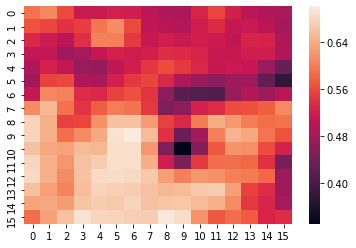

In [24]:
sns.heatmap(x[-2, :, :, -2])

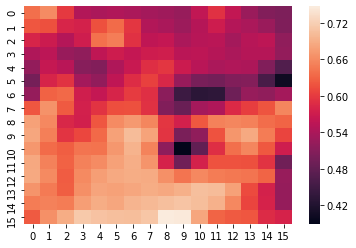

In [25]:
sns.heatmap(y[-2, :, :, -2])